# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:
>- PCA could reveal a large variance in spending amounts on prepared foods (Delicatessen category) vs unprepared (Fresh, Milk, Frozen).
- PCA might also show variance in the data of spending amounts on perishable goods (Fresh, Milk, Grocery) vs non-perishable (Frozen, Detergents_Paper).

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=len(data.columns), copy=True, whiten=False)

# fit the data
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 
> Variance drops by a small amount from the first to second dimension (.459 to .405), but then drops off dramatically to much lower variances (.044, .015, .006).

> I would use 2 dimensions as they appear to capture a much more significant portion of the data than the remaining 4 dimensions. Using 2 dimensions will also allow for plotting of the data, which may give further insight into how to create useful customer segments.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 
> The dimensions seem to represent correlations of spending amounts on each category, and (in order) how well they explain the variance in the data. The first dimension shows that spending on 'Fresh' is unrelated to the other categories, and the second dimension shows that spending on 'Milk', 'Grocery', and 'Detergents_Paper' are correlated.
     
> This information can be used to transform the dataset into fewer dimensions before applying a learner to create customer segments.

### ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA(n_components=None, algorithm='parallel', whiten=True, fun='logcosh', \
              fun_args=None, max_iter=200, tol=0.0001, w_init=None, random_state=None)

# fit the data
ica.fit(data)

# Print the independent components
print ica.components_

[[  3.97736736e-06  -8.75419323e-07  -7.15104814e-07  -6.61555067e-07
    2.26691909e-06  -9.99904713e-07]
 [  3.85724928e-07   2.18160169e-07   5.90825739e-07   5.37233735e-07
   -5.02946352e-07  -1.80952809e-05]
 [ -1.97107160e-07   1.77877022e-06  -7.13833397e-06  -3.17041934e-07
    2.46382509e-06   1.79094167e-06]
 [  2.81821043e-07  -2.50822634e-06  -1.15986464e-05   1.48544915e-06
    2.80604503e-05   5.71307308e-06]
 [  1.57437438e-07   9.81459316e-06  -5.90694517e-06  -3.47241324e-07
    3.59631787e-06  -6.01077794e-06]
 [  8.67352978e-07   1.43557078e-07  -7.71997445e-07  -1.11470119e-05
    5.39121252e-07   5.92444062e-06]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 
> Each vector transforms the features into a space where the new features provide no information about each other yet still retain mutual information with the original features. Each vector shows how to project the original data into the new space:
1. Put more weight on 'Fresh', 'Detergents_Paper'.
2. Put less weight on 'Delicatessen' -- this could be a customer segment based on a single category.
3. Put more weight on 'Milk', 'Detergents_Paper', 'Delicatessen'.
4. Put less weight on 'Grocery', somewhat less on 'Milk'.
5. Put more weight on 'Fresh', 'Milk', 'Detergents_Paper'.
6. Put less weight on 'Frozen', somewhat less on 'Grocery'.

> The components can be used to transform the data to recover the acutal source(s) of variation in category spending amounts, which could be associated with specific business types (or, customer segments) of the customers.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 
> **K Means**: Simple, fast, and effective method to partition data points into groups (clusters).

> **Gaussian Mixture Models**: Uses probability to determine likelihood of an example belonging to a cluster. Soft assignment can express uncertainty in cluster assignment (unlike K Means).

> K Means will be used because ...

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [5]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2, copy=True, whiten=False)
pca.fit(data)

reduced_data = pca.transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


#### How to choose number of clusters?
We can use [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py) to study the separation distance between potential clusters and choose an optimal value for `n_clusters`.
> The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

> Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters.

After examining the creation of 2 to 12 clusters, it appears that choosing 4 or fewer clusters will be most useful in producing meaningful cluster boundaries.

In [151]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2,12):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into cluster density and separation
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

('For n_clusters =', 2, 'The average silhouette_score is :', 0.54260629285749551)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.52291208240435094)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.46235710278169811)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.45182620708674198)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.43156890538615494)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.43356714476822628)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.41082645832635967)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.41156267643056577)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.38511328163771913)
('For n_clusters =', 11, 'The average silhouette_score is :', 0.39964497955065109)


In [155]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
est = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, \
             precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)

clusters = est.fit(reduced_data)
print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [156]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [157]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.cluster_centers_
print centroids

[[-24088.33276689   1218.17938291]
 [  4175.31101293   -211.15109304]]


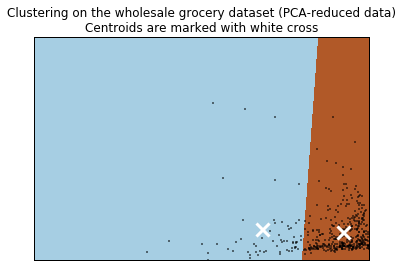

In [158]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### Show clustering with k=3

[[  4106.90273941  -3168.41202086]
 [  1497.13461172  24998.27760147]
 [-24220.71188261  -4364.45560022]]


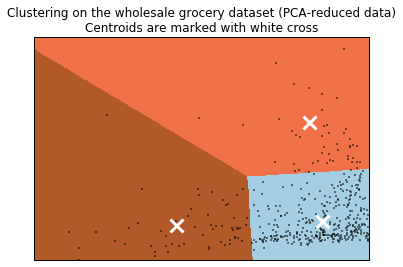

In [161]:
# fit data with different number of clusters
est = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, \
             precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)

clusters = est.fit(reduced_data)

# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

# Find the centroids for KMeans
centroids = clusters.cluster_centers_
print centroids
 
# Put the result into a color plot
# http://matplotlib.org/api/pyplot_api.html
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min/2, x_max)
plt.ylim(y_min, y_max/2)
plt.xticks(())
plt.yticks(())
plt.show()

#### Show clustering with k=5

[[ -9052.39957144  -4808.55909102]
 [-14537.71774395  61715.67085248]
 [  5607.91709853  14199.18040025]
 [-37704.64157991  -5488.35405895]
 [  6399.7117556   -4169.29690862]]


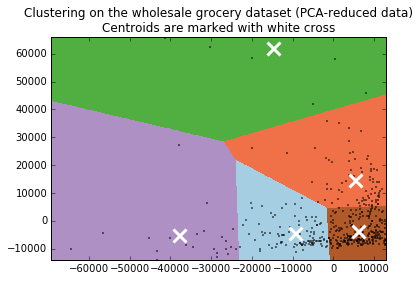

In [162]:
# fit data with different number of clusters
est = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, \
             precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)

clusters = est.fit(reduced_data)

# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

# Find the centroids for KMeans
centroids = clusters.cluster_centers_
print centroids

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min/1.5, x_max)
plt.ylim(y_min, y_max/1.5)
#plt.xticks(())
#plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
> The central objects are the centroids which indicate the point within a cluster where distance to the cluster's data points is minimized. In this example, they could represent the average or prototypical customer within that customer segment.

> Most of the data is located close together in the lower right corner of the plot, with clusters that aren't very well distinguished. The visualization might be improved by reducing the data to 3 dimensions instead of 2 and producing a 3d plot to see if more distinguished clusters can be revealed.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 
> ICA gave the most insight into the data by recovering hidden features within the data, which in this case would be customer segments or possibly even distinct types of businesses (eg, restaurant, bar, coffee shop, etc).

**9)** How would you use that technique to help the company design new experiments?

Answer: 
> The company could make another change to their delivery schedule and see if the different customer segments responded differently.

**10)** How would you use that data to help you predict future customer needs?

Answer: 
> Knowing how a particular customer segment responds to a given delivery schedule could be used to predict a new customer's delivery schedule preference or an existing customer's delivery schedule preference if it changed its spending profile.